# MORL for water resource management

## Goals
Evaluate and compare novel MORL algorithms on a simulated water-reservoir environment (https://github.com/Farama-Foundation/MO-Gymnasium).

Algorithms:
- GPI-ls + TD3
- PCN

The returns used for the plotted pareto fronts are the discounted returns averaged over 5 episodes (default), unless specified otherwise.

# TODO...

- Tune hyperparameters/environment to get improved results using GPI-ls
- Decide between normalized actions or true actions
- Get a reference for comparing with GPI-ls results: PCN, [original experiment](https://github.com/sparisi/mips/tree/loopless/MDPs/Dam)

In [5]:
import mo_gymnasium as mo_gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from morl_baselines.multi_policy.gpi_pd.gpi_pd_continuous_action import GPIPDContinuousAction

"""
Helper function to plot pf
"""
# TODO: add no objectives as parameter (later)
def plot_pf(file):
    columns = ["objective_1", "objective_2"]
    df = pd.read_csv(file, usecols=columns)

    plt.plot(df.objective_1, df.objective_2, 'o')
    plt.xlabel('Cost due to excess water level wrt flooding threshold upstream')
    plt.ylabel('Deficit in water supply wrt demand')
    plt.show()

## GPI-ls with TD3
Try this without the dynamics model for a fair comparison with PCN (later).

Algo parameters:
- per = True
- policy_noise = 0.002
- noise_clip = 0.005
- rest is default

Opt for smaller policy noise due to normalized actions. Note: normalized actions are learned/returned by the policy and converted to true actions before being taken by the environment.

Noise is calculated by:
- Obtain action from policy net (given the state and a weight vector). The action predicted bythe
- Obtain an equal-sized vector filled with random gaussians (mean 0 variance 1) clamped within [-noise_clip;noise_clip] and multiply with noise
- action + random_noise and clamp within -1 and 1.
- Multiply with action_scale = (action_high - action_low) / 2 and add action_bias = (action_high + action_low) / 2

Environment parameters:
- normalized_action = True
- penalize = True
- time_limit = 365 

### Bug?
Algorithm returns nan as values for ccs when normalized_action=False

    C:\Users\liamm\anaconda3\lib\site-packages\mo_gymnasium\envs\water_reservoir\dam_env.py:261: RuntimeWarning: invalid value encountered in multiply penalty = -self.penalize * np.abs(bounded_action - action)
    
This is probably caused by the use of action_space.high in the action_scale and action_bias buffers of the policy net

=> TEMP Fix: when placing an upper bound on the action other than np.inf (dam_env.py, line 113), agent trains. Maybe agents selects np.inf as action sometimes?

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise', policy_noise=0.002, noise_clip=0.005)

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650) #random ref_point, hv is not used in the algorithm so this does not matter for training

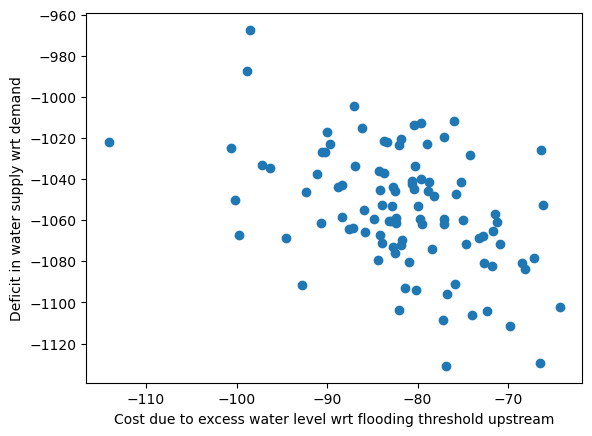

In [7]:
plot_pf('2obj_norm_lessPNoise.csv')

## Experiment with TD3 hyperparameters: Attempt #1

- net_arch = [500]

opt for single layer NN

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers', policy_noise=0.002, noise_clip=0.005, net_arch=[500])

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650)

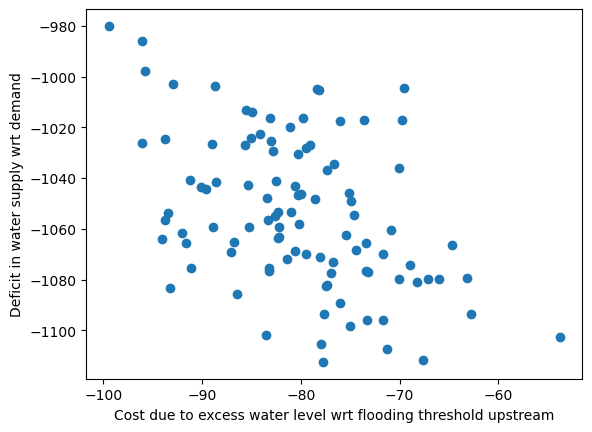

In [8]:
plot_pf("2obj_norm_lessPNoise_Hlayer500.csv")

When looking at the resulting solution set, the returns have improved slightly. We'll try to experiment more with the hidden layer configuration.

### Attempt #2

- net_arch = [200]

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers200', policy_noise=0.002, noise_clip=0.005, net_arch=[200])

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650)

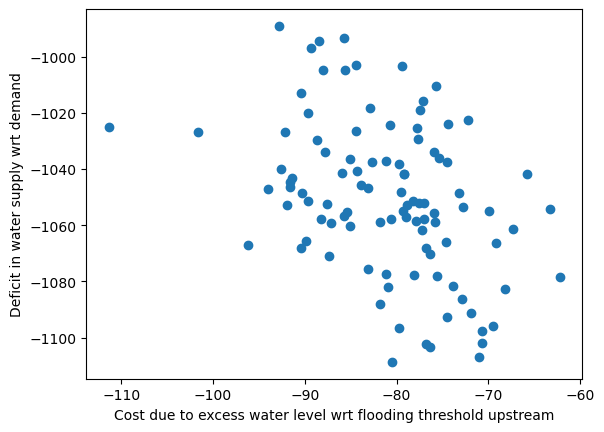

In [9]:
plot_pf("2obj_norm_lessPNoise_Hlayer200.csv")

The results are no better than in previous experiments, but there might be a case of [catastrophic forgetting](https://en.wikipedia.org/wiki/Catastrophic_interference): The mean utility increases up to a certain timestep and then decreases. Another explanation might be that there is insufficient exploration due to lower policy noise and learning_starts = 100 timesteps. Investigate...

Next, we could try to alter [batch size](https://openreview.net/pdf?id=B1Yy1BxCZ) or [buffer size](https://ai.stackexchange.com/questions/11640/how-large-should-the-replay-buffer-be). And take a look at the randomness of the environment.

The hidden layer configuration does not impact learning significantly, so the default setup suffices.

## Comparison with original paper

In [this paper](https://iwaponline.com/jh/article/15/2/258/3425/Tree-based-fitted-Q-iteration-for-multi-objective) an experiment on the same simulated dam environment was conducted. Their results are a lot better, but the environment was only simulated for 100 timesteps/episode instead of the 365 used here. 

Also note that the returns used in the paper correspond to the average immediate rewards under each policy (instead of the discounted returns used here).

We now conduct an experiment to test the randomness of the environment and see if this influences the mean utility. In order to test this, evaluate the policy for significantly more episodes (50) 

In order to reduce training time, set time_limit = 100 (default, as in paper)

In [3]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers500_bufferSize3650', policy_noise=0.002, noise_clip=0.005, net_arch=[500])

GPIAgent.train(100000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=50)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers500_bufferSize3650


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [ -89.0323 -671.4115] to CCS.
Adding value: [ -55.1178 -676.9745] to CCS.


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0.1409, 0.8591]), array([0., 1.])] W_corner size: 3
CCS: [array([ -89.0323, -671.4115], dtype=float32), array([ -55.1178, -676.9745], dtype=float32)] CCS size: 2
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [ -54.2932 -685.0519] to CCS.
removed value [ -55.1178 -676.9745]
Adding value: [ -55.3127 -681.4085] to CCS.
Value [ -55.3127 -681.4085] is dominated. Discarding.
Adding value: [ -49.0894 -688.355 ] to CCS.
removed value [ -54.2932 -685.0519]
Adding value: [ -57.5461 -687.8972] to CCS.
Value [ -57.5461 -687.8972] is dominated. Discarding.
Adding value: [ -55.1078 -675.7437] to CCS.
W_corner: [array([0.6769, 0.3231]), array([1., 0.]), array([0., 1.]), array([0.1132, 0.8868])] W_corner size: 4
CCS: [array([ -89.0323, -671.4115], dtype=float32), array([ -49.0894, -688.355 ]), array([ -55.1078, -675.7437])] CCS size: 3
Next weight: [0.6769 0.3231]
Next weight vector: [0.6769 0.3231]
Adding value: [ -49.3499 -692.3153] to CCS.
Value [

eval/Mean Utility - GPI,▄▁▂▁▂▁▂▄▇█
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,-369.20566
iteration,10


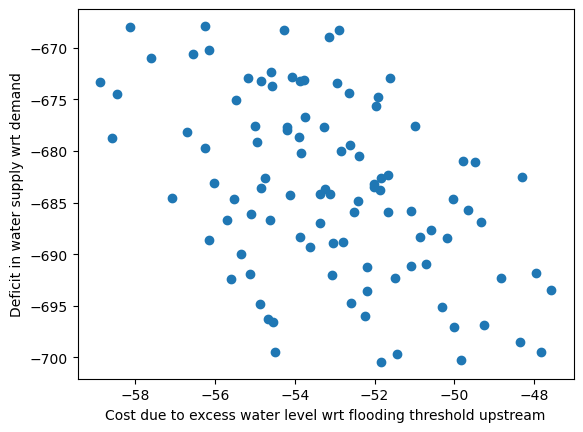

In [3]:
plot_pf('2obj_norm_lessPNoise_Hlayer500_eval50.csv')

When looking at the eval/mean utilty graph over time, the mean utility rises, but this is on a very small scale: an increase of +.200. 

## Try using non-normalized actions

Because the TD3 network expects a range of actions (for noise scaling purposes), the given upper bound of the action space np.inf is not usable in practice => Manually place upper bound on the action space:
- Upper bound = 250.0

The intuition for this bound is that the lower bound for taking an action is determined by np.clip(state - 100, 0, None). The upper bound is the state itself. With an inflow of X~(40;10), the max inflow is around 80. Whenever the state exceeds 100, the minimum allowed action will be a release of the excess above 100, which means that theoretically, the max state at any time point is around 180. Considering that the upper bound on an action is the state itself we can conclude that 250 is a good bound to place upon the action space. 

Due to the penalty on the reward function when an action larger than the state is taken, the policy will learn to avoid these actions.

Also increase learning_starts to explore the environment a little more initially and boost learning.

In [2]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj', learning_starts=1000)

GPIAgent.train(200000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=25)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-214.8958 -657.5945] to CCS.
Adding value: [-169.8212 -651.1689] to CCS.
removed value [-214.8958 -657.5945]


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([-169.8212, -651.1689], dtype=float32)] CCS size: 1
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-104.3247 -692.6697] to CCS.
Adding value: [-549.2895 -607.1148] to CCS.
removed value [-169.8212 -651.1689]
Adding value: [-118.5576 -696.2566] to CCS.
Value [-118.5576 -696.2566] is dominated. Discarding.
W_corner: [array([1., 0.]), array([0.1613, 0.8387]), array([0., 1.])] W_corner size: 3
CCS: [array([-104.3247, -692.6697], dtype=float32), array([-549.2895, -607.1148])] CCS size: 2
Next weight: [0.1613 0.8387]
Next weight vector: [0.1613 0.8387]
Adding value: [-211.0012 -692.3654] to CCS.
Value [-211.0012 -692.3654] is dominated. Discarding.
Adding value: [-1248.9389  -639.3292] to CCS.
Value [-1248.9389  -639.3292] is dominated. Discarding.
Adding value: [-215.07   -687.4335] to CCS.
Value [-215.07   -687.4335] is dominated. Discarding.
Adding value: [-1405.9442  -624.1142] to CCS.
Value [-1405

eval/Mean Utility - GPI,▃▅▁▅▄▇█▇▇█▇█▇▇▅█▇▇▇█
iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
eval/Mean Utility - GPI,-373.48984
iteration,20


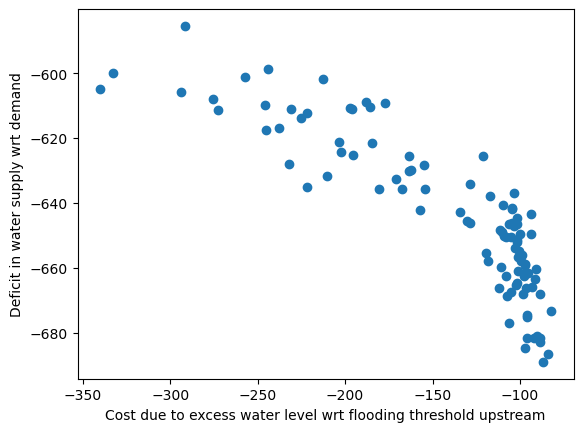

In [2]:
plot_pf('2obj_pen.csv')

Results are slightly worse than when using normalized actions. BUT, when compared to the experiments with normalised actions, it is noticable that the returns of the water demand objective (y-axis) are higher than before.

## TODO:

Make some changes to the environment:
- Reduce randomness to test whether the algorithm has implementation issues or the environment is too random
- Test what the impact of using normalized actions is, because results differ heavily from using non-normalized actions

Change algorithm logging for fair comparison with [this paper](https://iwaponline.com/jh/article/15/2/258/3425/Tree-based-fitted-Q-iteration-for-multi-objective):
- Log the undiscounted returns instead of discounted

## Increase initial exploration (normalized actions)

Run the same experiment again but now using normalised actions to see the impact of initial exploration and see if using norm. actions is correlated to lower returns in the 2nd objective.

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_norm', learning_starts=1000)

GPIAgent.train(200000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=25)

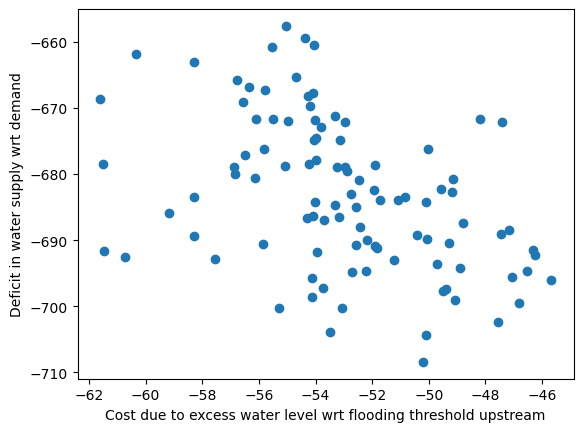

In [3]:
plot_pf('./2obj_norm_moreInitExpl.csv')

Once again, the flooding objective has has better returns. When compared to the experiment where learning_starts is set at lower value, the returns have improved very slightly.


## Reducing the stochasticity of the environment

The dam inflow was previously determined by a normal distribution with mean 40 and std 10.

Try to reduce the stdev to 1 to get an understanding of the influence of the randomness on the algorithm:

### Normalised actions

Less eval episodes are needed because of the decrease in randomness

In [2]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_norm_lowerstdev', learning_starts=1000)

GPIAgent.train(200000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_norm_lowerstdev


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [   0.     -638.4866] to CCS.
Adding value: [   0.    -636.994] to CCS.
removed value [   0.     -638.4866]


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([   0.   , -636.994], dtype=float32)] CCS size: 1
Next weight: [0. 1.]
Next weight vector: [0. 1.]
Adding value: [   0.     -636.3579] to CCS.
removed value [   0.    -636.994]
Adding value: [   0.     -638.8249] to CCS.
Adding value: [   0.     -636.3111] to CCS.
removed value [   0.     -638.8249]
removed value [   0.     -636.3579]
W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([   0.    , -636.3111])] CCS size: 1
Next weight: [0. 1.]
Next weight vector: [0. 1.]
Adding value: [   0.     -638.7521] to CCS.
Adding value: [   0.     -636.0081] to CCS.
removed value [   0.     -638.7521]
removed value [   0.     -636.3111]
Adding value: [   0.     -634.9864] to CCS.
removed value [   0.     -636.0081]
W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([   0.    , -634.9864])] CCS size: 1
Next weight: [0. 1.]
Next weight vector: [0. 1.]
Adding value: [   0.     -645

KeyboardInterrupt: 

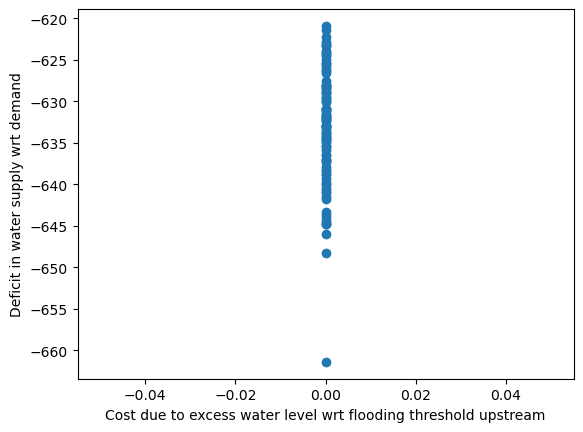

In [2]:
plot_pf('./2obj_norm_lessvariance.csv')

These results do not prove anything: The policy can learn the optimal actions to maximize the flooding objective (theoretically possible), but does not make any tradeoffs to optimize for the second objective...

### Absolute actions

- Capped at 250.0
- stdev = 1.0

In [7]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_lowerstdev', learning_starts=4000)

GPIAgent.train(200000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=15)

eval/Mean Utility - GPI,▁█████▁██████
iteration,▁▂▂▃▃▄▅▅▆▆▇▇█
eval/Mean Utility - GPI,-5642.72404
iteration,13


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_lowerstdev


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-13285.384 -13924.971] to CCS.
Adding value: [-13293.071  -13928.2705] to CCS.
Value [-13293.071  -13928.2705] is dominated. Discarding.
W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([-13285.384, -13924.971], dtype=float32)] CCS size: 1
Next weight: [0. 1.]
Next weight vector: [0. 1.]
Adding value: [-13268.645 -13901.002] to CCS.
removed value [-13285.384 -13924.971]
Adding value: [-13261.4105 -13892.6013] to CCS.
removed value [-13268.645 -13901.002]
Adding value: [-13292.9098 -13927.5331] to CCS.
Value [-13292.9098 -13927.5331] is dominated. Discarding.
W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([-13261.4105, -13892.6013])] CCS size: 1
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-13256.7287 -13881.9043] to CCS.
removed value [-13261.4105 -13892.6013]
Adding value: [-13274.5413 -13903.0629] to CCS.
Value [-13274.5413 -13903.

eval/Mean Utility - GPI,▁▁▁▁▅███████████████
iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
eval/Mean Utility - GPI,-316.23312
iteration,20


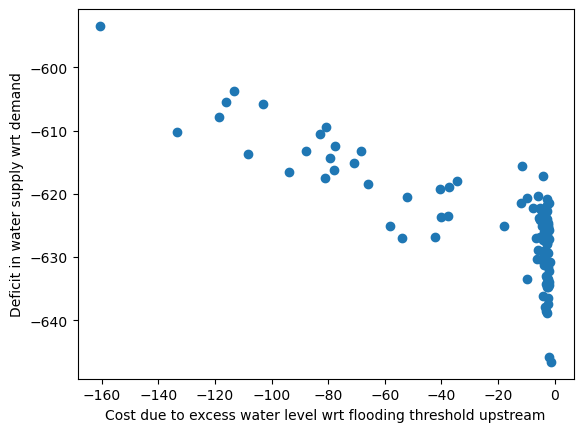

In [8]:
plot_pf('./2obj_lessVariance.csv')

The flooding objective can be maximized easily because dam inflow is less stochastic. The water supply also benefits somewhat because it is easier to keep the water level at or above the demand.